In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the required libraries**

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<ipython-input-2-fd2b3670d061>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# **Visualize the Data**

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
# Classes Directories
# NonViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
NonViolnceVideos_Dir = "/content/drive/MyDrive/BigData/Class 0 - Safe"

# ViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"
ViolnceVideos_Dir = "/content/drive/MyDrive/BigData/Class 1 - Fantasy Violence"

SexVideos_Dir = "/content/drive/MyDrive/BigData/Class 2 - Sex, Nudity"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)
SexVideos_files_names_list = os.listdir(SexVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)
Random_Sex_Video = random.choice(SexVideos_files_names_list)


**Play Random Non Violence Video**

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

**Play Random Violence Video**

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [ ]:
Play_Video(f"{SexVideos_Dir}/{Random_Sex_Video}")

# **Extracting Frames**

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

DATASET_DIR = "/content/drive/MyDrive/BigData"

CLASSES_LIST = ["Class 0 - Safe","Class 1 - Fantasy Violence","Class 2 - Sex, Nudity"]

In [ ]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

# **Creating the Data**

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Class 0 - Safe
Extracting Data of Class: Class 1 - Fantasy Violence
Extracting Data of Class: Class 2 - Sex, Nudity


In [ ]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [ ]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(153, 20, 128, 128, 3) (153, 3)
(17, 20, 128, 128, 3) (17, 3)


# **Importing ResNet and Fine-Tuning it.**

> Add blockquote



In [ ]:
from keras.layers import Input
from keras.layers import ZeroPadding2D
from keras.layers import Conv2D
from keras.initializers import glorot_uniform
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM, Dropout

# Load the VGG16 model without the top layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Make the base model non-trainable
for layer in model.layers:
    layer.trainable = False

# Summary of the model
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

# **Building The Model**

In [ ]:
def create_model(input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=3):
    model = Sequential()

    # Input shape for Conv3D: (frames, height, width, channels)
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    # Block 2
    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # Block 3
    model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # Block 4
    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # Block 5
    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), padding="same", activation="relu"))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes, activation='softmax'))

    return model

In [ ]:
# Constructing the Model
VVG16 = create_model()

# Plot the structure of the contructed LRCN model.
# plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Spark Pipeline**


In [ ]:
# Train
# Convert numpy arrays to lists of tuples
data_train = [(features_train[i].tolist(), labels_train[i].tolist()) for i in range(len(features_train))]

# Define schema for the DataFrame
schema = StructType([
    StructField("features train", ArrayType(ArrayType(ArrayType(ArrayType(FloatType())))), True),
    StructField("labels train", ArrayType(FloatType()), True)
])

# Create DataFrame
train_df = spark.createDataFrame(data_train, schema)

#Test
# Convert numpy arrays to lists of tuples
data_test = [(features_test[i].tolist(), labels_test[i].tolist()) for i in range(len(features_test))]

# Define schema for the DataFrame
schema = StructType([
    StructField("features test", ArrayType(ArrayType(ArrayType(ArrayType(FloatType())))), True),
    StructField("labels test", ArrayType(FloatType()), True)
])

# Create DataFrame
test_df = spark.createDataFrame(data_test, schema)


In [ ]:
train_df.show()
test_df.show()

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labels, features, model])
# # Fit model to data
# train_data = labels_train.join(features_train, "common_key")
# fitted_pipeline = pipeline.fit(train_data)
# # Evaluate on train data.
# prediction = fitted_pipeline.transform(train_data)


# **Specifying Callbacks and Fitting**

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.6,
                                                 patience=5,
                                                 min_lr=0.00005,
                                                 verbose=1)

# Compiling the model
VVG16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
VVG16_model_history = VVG16.fit(x=features_train, y=labels_train, epochs=25, batch_size=8,
                                              shuffle=True, validation_split=0.2,
                                              callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/25
16/16 [==============================] - 1684s 105s/step - loss: 1.3018 - accuracy: 0.5082 - val_loss: 1.7153 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 2/25
 5/16 [========>.....................] - ETA: 18:25 - loss: 0.7663 - accuracy: 0.5250

KeyboardInterrupt: 

In [ ]:
model_evaluation_history = VVG16.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 276ms/step - loss: 1.0364 - accuracy: 0.5556


# **Model Evaluation**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

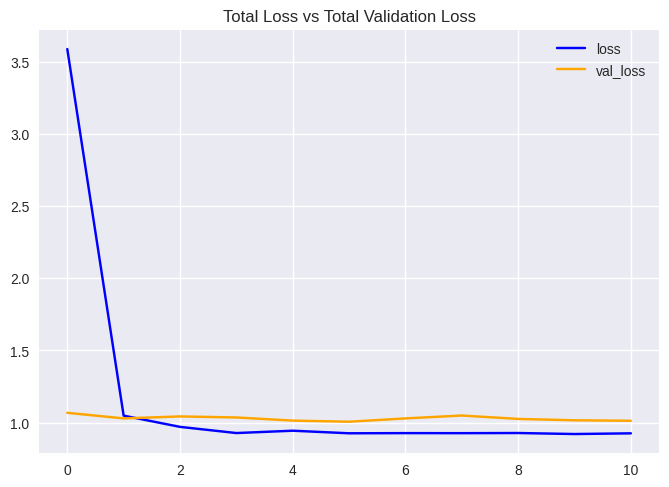

In [ ]:
plot_metric(VVG16_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

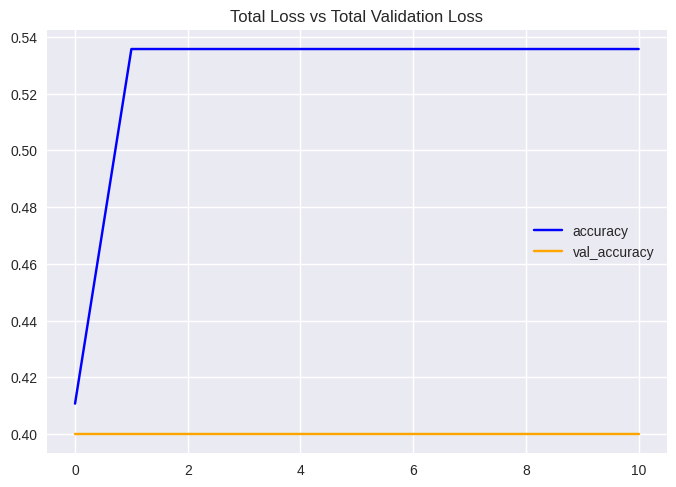

In [ ]:
plot_metric(VVG16_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# **Predicting the Test Set**

In [ ]:
labels_predict = VVG16.predict(features_test)

1/1 [==============================] - 0s 231ms/step


In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

((18,), (18,))

Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.5555555555555556


Confusion Matrix

Classification Report

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.56      1.00      0.71        10

    accuracy                           0.56        18
   macro avg       0.28      0.50      0.36        18
weighted avg       0.31      0.56      0.40        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Prediction Frame By Frame**

In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = VVG16.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:

import matplotlib.pyplot as plt
import cv2
import random

plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):

        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.imshow(frame)
        ax = plt.gca()  # Get the current axes
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()


In [ ]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 17ms/step


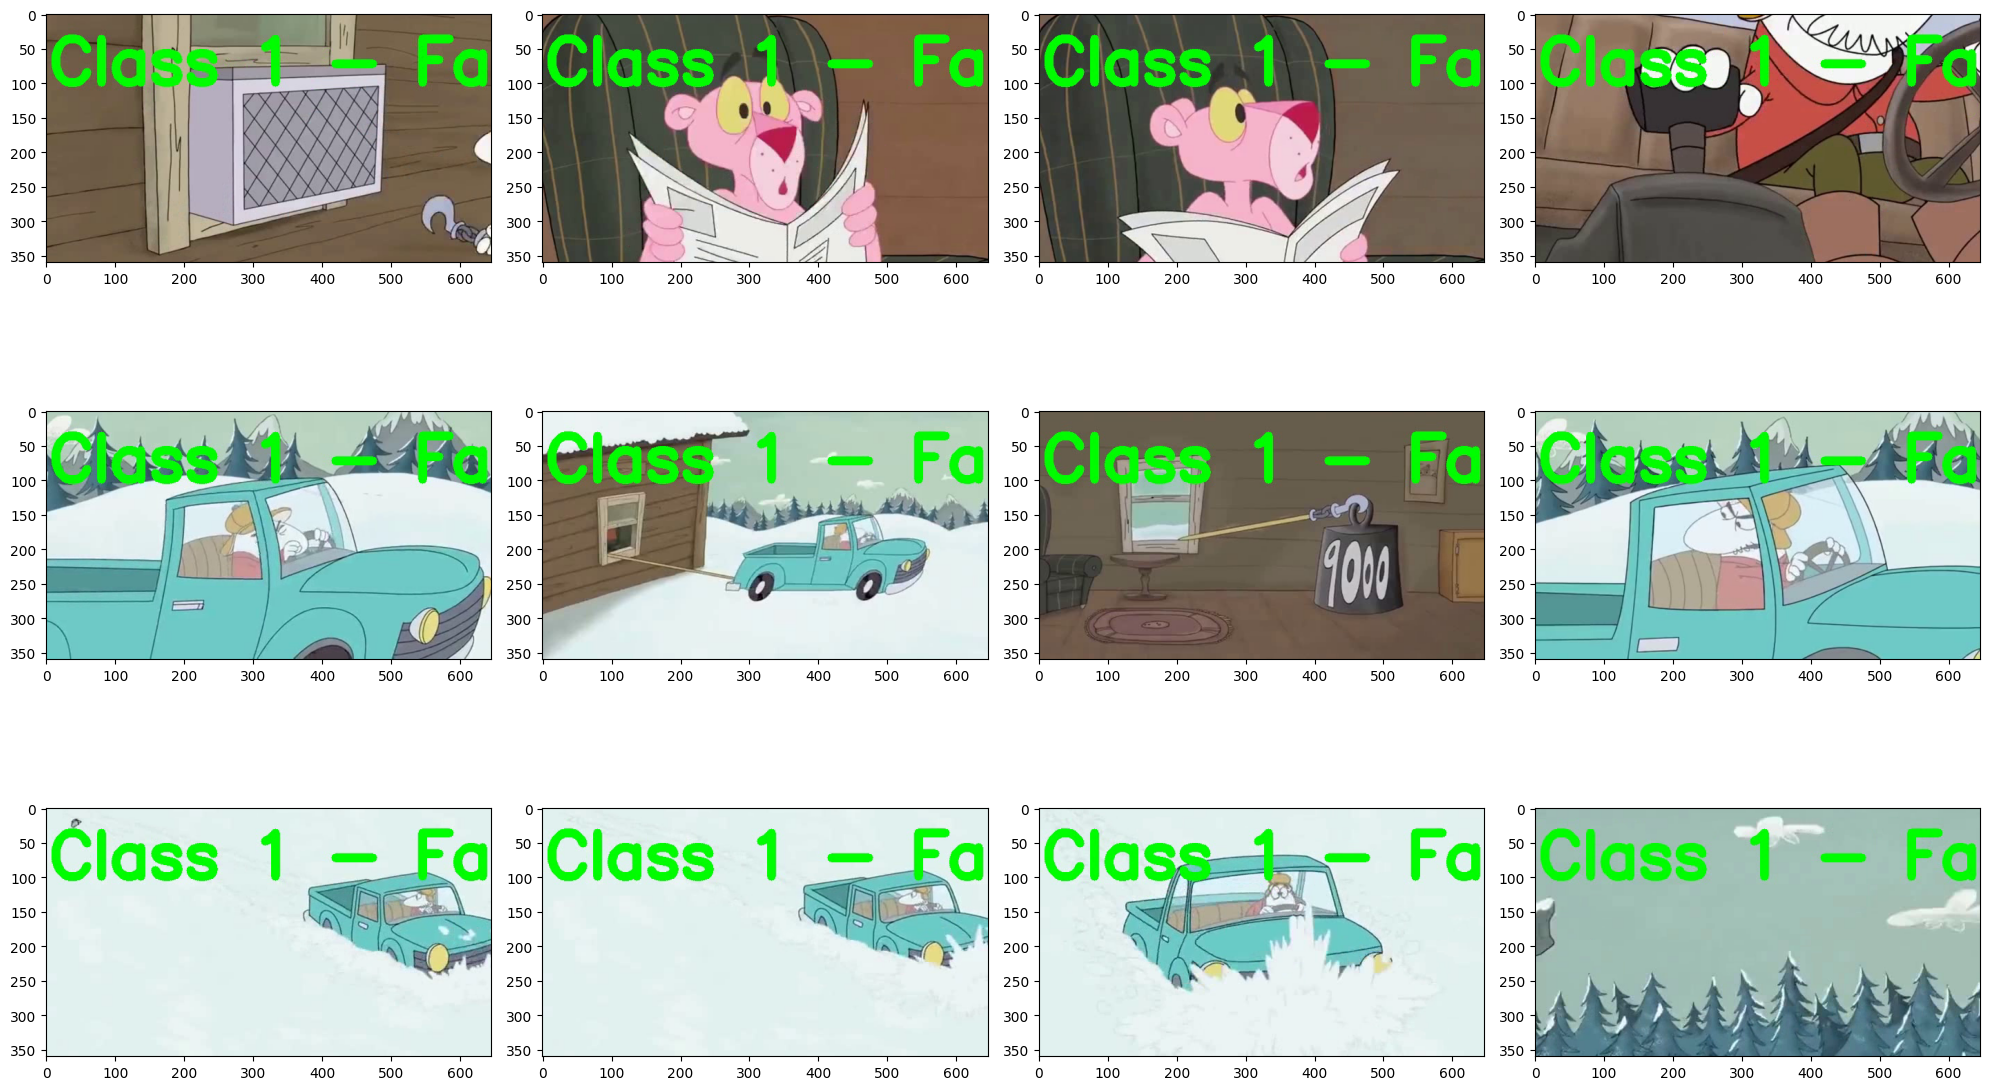

In [ ]:
# Specifying video to be predicted
# input_video_file_path = "/content/drive/MyDrive/BigData/notLabelVideos/Familyguy/familyguy 463.mp4"
# /content/drive/MyDrive/BigData/Class 0 - Safe/Video_10.mp4

input_video_file_path = "/content/drive/MyDrive/BigData/Class 0 - Safe/Video_10.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
# Play_Video(input_video_file_path)

1/1 [==============================] - 0s 18ms/step


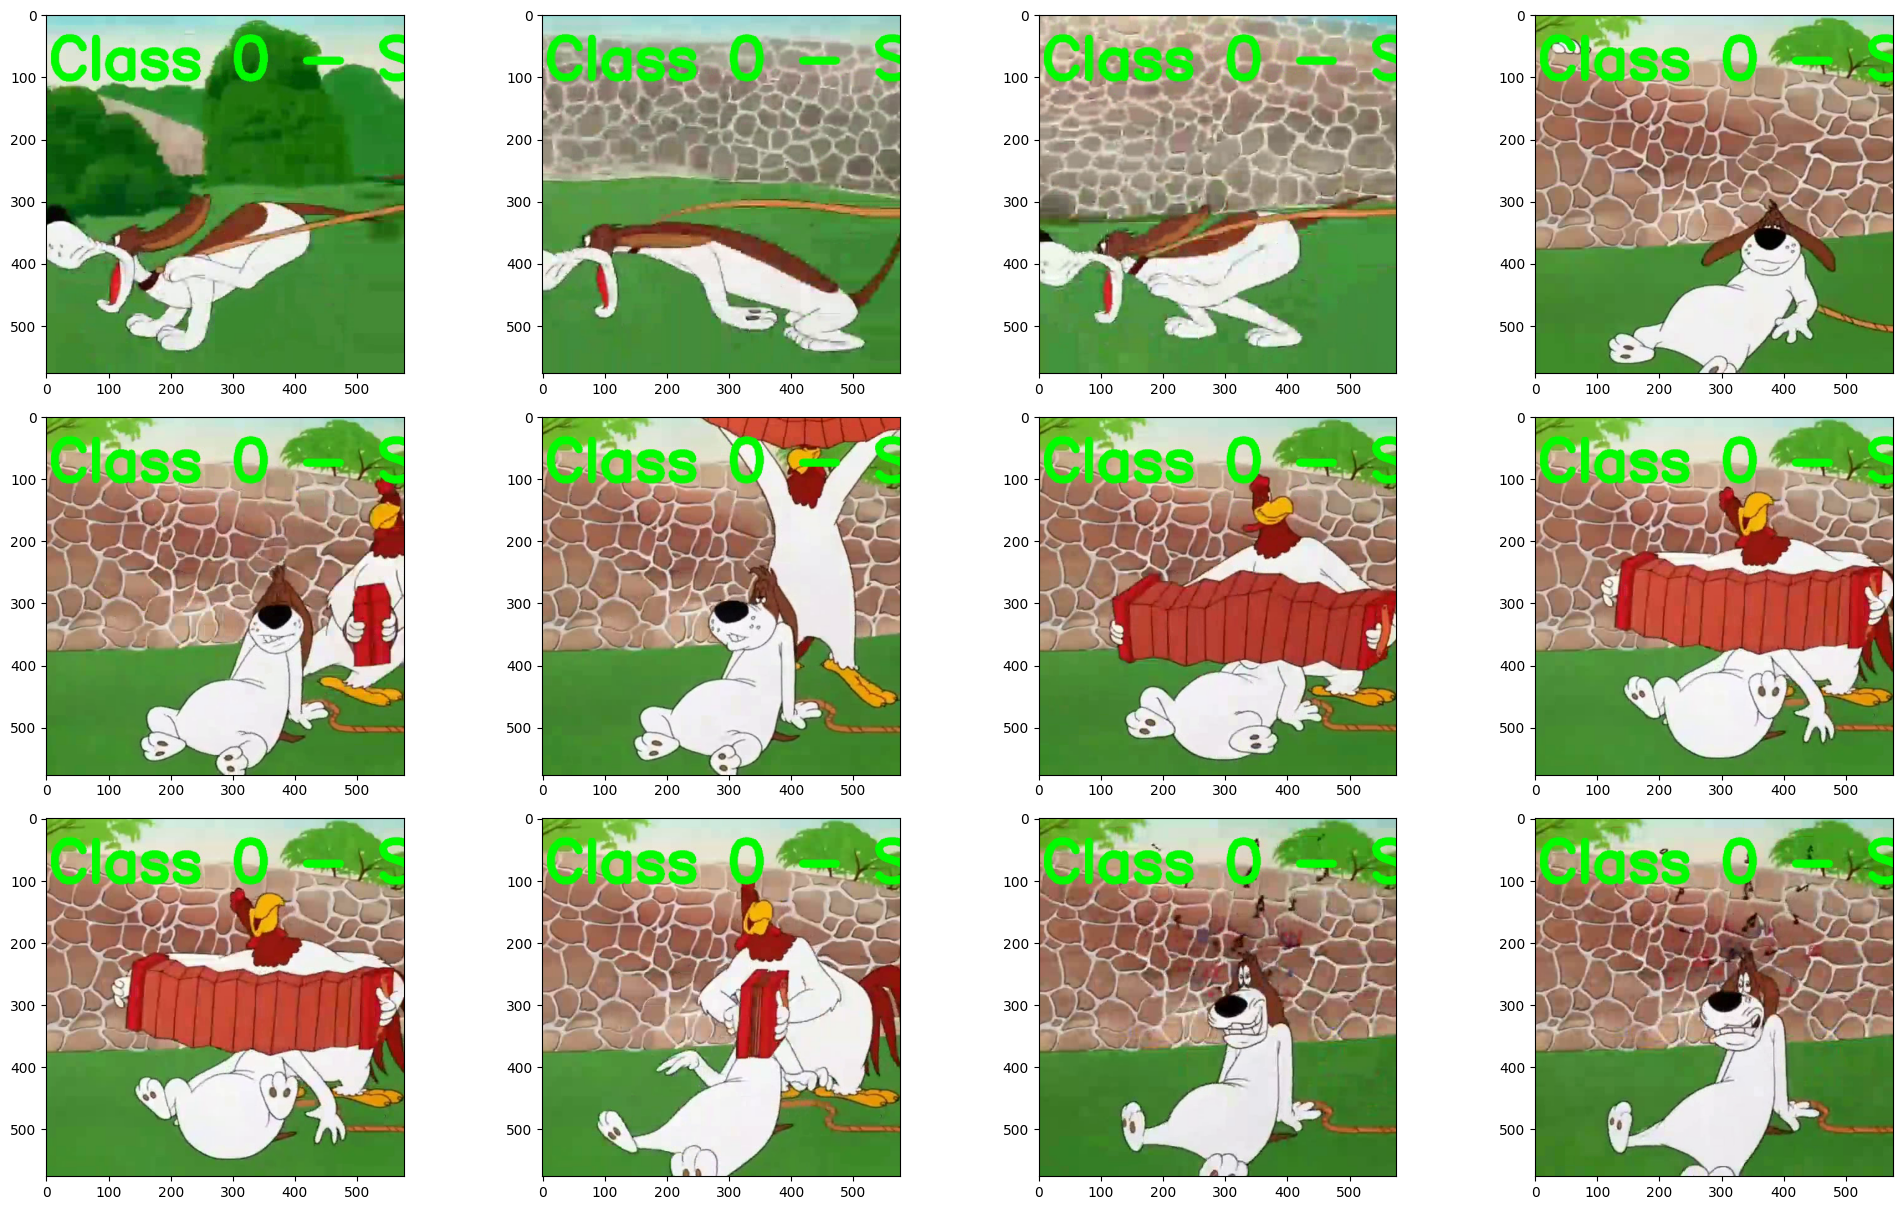

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/BigData/Class 1 - Fantasy Violence/Video_3.mp4"
# /content/drive/MyDrive/BigData/Class 2 - Sex, Nudity/Video_1.mp4
# /content/drive/MyDrive/BigData/Class 1 - Fantasy Violence/Video_3.mp4
# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
# Play_Video(input_video_file_path)

# **Prediction For The Video**

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = ResBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/BigData/Class 1 - Fantasy Violence/Video_19.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

NameError: name 'ResBiLSTM_model' is not defined

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/drive/MyDrive/BigData/Class 0 - Safe/Video_22.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)